        provider_number  year  report_count
0                 10001  1997             1
1                 10001  1998             1
2                 10001  1999             1
3                 10001  2000             1
4                 10001  2001             1
...                 ...   ...           ...
120467           673063  2016             1
120468           673063  2017             1
120469           673064  2016             1
120470           673064  2017             1
120471           673065  2016             1

[120472 rows x 3 columns]


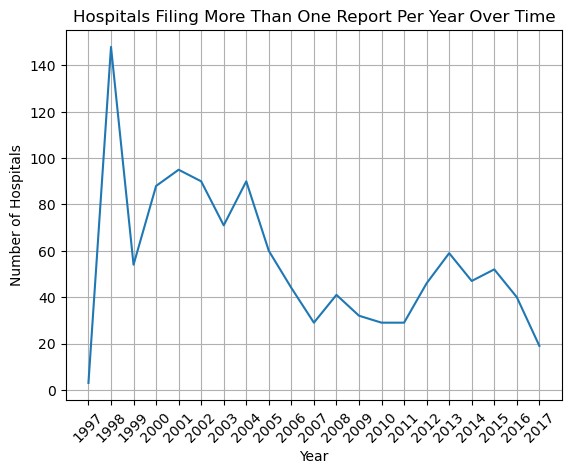

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read in data
hcris_data=pd.read_csv('/Users/ryanscholte/Desktop/GitHub/HW2/data/output/HCRIS_Datac.csv')


# Convert 'fy_start' to datetime to extract the year
hcris_data['fy_start'] = pd.to_datetime(hcris_data['fy_start'], errors='coerce')
hcris_data['year'] = hcris_data['fy_start'].dt.year

# Count hospitals that filed more than one report in the same year
hospital_counts = hcris_data.groupby(['provider_number', 'year']).size().reset_index(name='report_count')
multiple_reports = hospital_counts[hospital_counts['report_count'] > 1]

# Count number of hospitals per year
hospitals_over_time = multiple_reports.groupby('year')['provider_number'].nunique()

print(hospital_counts)
# Plot the results
plt.figure()
plt.plot(hospitals_over_time.index, hospitals_over_time.values)
plt.xlabel('Year')
plt.xticks(hospitals_over_time.index, rotation=45) 
plt.ylabel('Number of Hospitals')
plt.title('Hospitals Filing More Than One Report Per Year Over Time')
plt.grid(True)
plt.show()


In [3]:
# Remove duplicate reports by keeping only the first occurrence per hospital per year
unique_hospitals = hcris_data.drop_duplicates(subset=['provider_number', 'year'])

# Count the number of unique hospital IDs (Medicare provider numbers)
unique_hospital_count = unique_hospitals['provider_number'].nunique()

# Display the result
print("Number of unique hospital IDs:", unique_hospital_count)

Number of unique hospital IDs: 9323


count    1.169650e+05
mean     3.275195e+08
std      6.921151e+08
min      0.000000e+00
25%      2.540091e+07
50%      7.999620e+07
75%      3.291725e+08
max      1.863371e+10
Name: tot_charges, dtype: float64


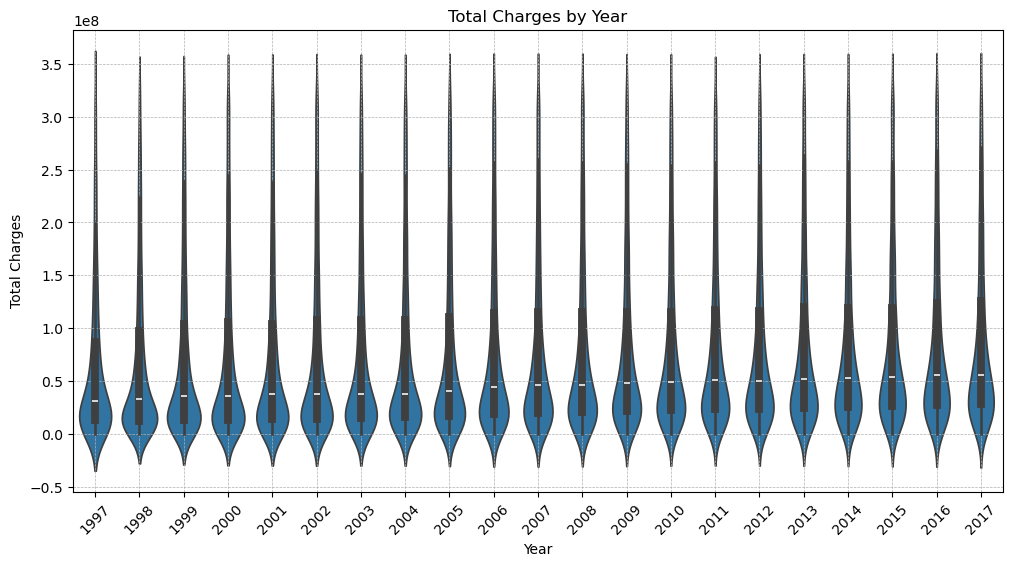

In [4]:
import seaborn as sns
#Question 3
hcris_data['tot_charges'] = pd.to_numeric(hcris_data['tot_charges'], errors='coerce')
# Convert tot_charges to numeric
hcris_data['tot_charges'] = pd.to_numeric(hcris_data['tot_charges'], errors='coerce')
#Remove rows with missing charges or years, negative values, and outliers
charges_by_year = hcris_data[['year','tot_charges']].dropna ()
charges_by_year = charges_by_year [charges_by_year['tot_charges'] >= 0]
# Display summary statistics to find cutoff values
summary_stats = charges_by_year ['tot_charges']. describe ()
print (summary_stats)
#creating upper bound limit
upper_bound = summary_stats['75%'] if '75%' in summary_stats else summary_stats['max']
charges_by_year = charges_by_year [charges_by_year['tot_charges'] <= upper_bound]
#charges_by_year['log_tot_charges'] = np.log(charges_by_year['tot_charges'] + 1)  # Adding 1 to avoid log(0)

# Plot violin plot
plt.figure(figsize=(12, 6)) 
sns.violinplot (x='year', y='tot_charges', data=charges_by_year)
plt.title("Total Charges by Year")
plt.xlabel ("Year")
plt.ylabel("Total Charges")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show( )



count    5.903200e+04
mean              inf
std               NaN
min      1.953267e+00
25%      4.806754e+03
50%      7.161668e+03
75%      1.034881e+04
max               inf
Name: estimated_price, dtype: float64


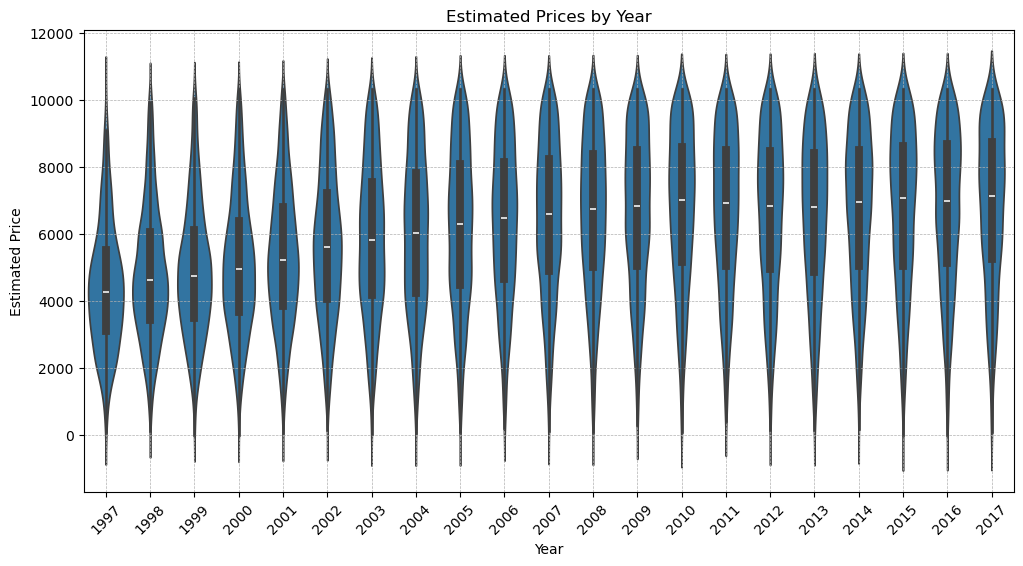

In [5]:
#Question 4
#Converting columns to numeric
numeric_columns = [
    'tot_discounts', 'tot_charges',
    'ip_charges', 'icu_charges', 'ancillary_charges',
    'tot_mcare_payment', 'tot_discharges', 'mcare_discharges'
]
hcris_data[numeric_columns] = hcris_data[numeric_columns].apply(pd.to_numeric, errors='coerce')
# Remove missing values
hcris_clean = hcris_data[['year'] + numeric_columns].dropna( )
# Calculate estimated price based on the formula
discount_factor = 1 - hcris_clean['tot_discounts'] / hcris_clean ['tot_charges']
price_num = (hcris_clean['ip_charges'] + hcris_clean['icu_charges'] + hcris_clean['ancillary_charges']) * discount_factor - hcris_clean[ 'tot_mcare_payment']
price_denom = hcris_clean['tot_discharges'] - hcris_clean ['mcare_discharges']
hcris_clean['estimated_price'] = price_num/price_denom
#removing outliers and negatives
hcris_clean = hcris_clean[hcris_clean['estimated_price'] > 0]

summary_stats = hcris_clean['estimated_price'].describe()
print (summary_stats)
upper_bound = summary_stats ['75%'] if '75%' in summary_stats else summary_stats ['max']
hcris_clean = hcris_clean[hcris_clean['estimated_price'] <= upper_bound]
#Plot violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='year', y='estimated_price', data=hcris_clean)
plt.title("Estimated Prices by Year")
plt.xlabel ("Year")
plt.ylabel("Estimated Price")
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt. show()

In [6]:
#Q5.

# Filter data to only include year 2012
hcris_2012 = hcris_data[hcris_data['year'] == 2012].copy()

# Calculate estimated price using the given formula
hcris_2012['discount_factor'] = 1 - (hcris_2012['tot_discounts'] / hcris_2012['tot_charges'])
hcris_2012['price_num'] = (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges']) * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Define penalty
hcris_2012['penalty'] = (hcris_2012['hrrp_payment'] + hcris_2012['hvbp_payment']) < 0

# Clean data
hcris_2012 = hcris_2012[(hcris_2012['price_denom'] > 100) & (hcris_2012['price_num'] > 0) & (hcris_2012['price'] > 0)]
hcris_2012 = hcris_2012[hcris_2012['beds'] > 30]
hcris_2012 = hcris_2012[hcris_2012['price'] < 100000]  # As in the R code

# NA payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()


# Calculate average price for penalized vs non-penalized hospitals
mean_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean(), 2)
mean_non_penalized = round(hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean(), 2)

print(f"Mean price for penalized hospitals: {mean_penalized}")
print(f"Mean price for non-penalized hospitals: {mean_non_penalized}")

Mean price for penalized hospitals: 9496.43
Mean price for non-penalized hospitals: 9699.71


In [7]:
#Q6
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    hcris_2012[f'quartile_{i}'] = (hcris_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 1), 'price'].mean()
    control_mean = hcris_2012.loc[(hcris_2012[f'quartile_{i}'] == 1) & (hcris_2012['penalty'] == 0), 'price'].mean()
    Avg_per_group.append({'Quartile': i, 'Treated_Mean_Price': round(treated_mean, 2), 'Control_Mean_Price': round(control_mean, 2)})

results_df = pd.DataFrame(Avg_per_group)
print(results_df)

   Quartile  Treated_Mean_Price  Control_Mean_Price
0         1             6655.93             7853.99
1         2             9418.92             8564.88
2         3             9793.63             9921.73
3         4            11682.48            12503.75


In [8]:
from causalinference import CausalModel
# Step 1: Define treatment (penalized) and control groups
hcris_2012['treated'] = (hcris_2012['penalty'] > 0).astype(int)
treated_df = hcris_2012[hcris_2012['treated'] == 1]
control_df = hcris_2012[hcris_2012['treated'] == 0]

# Step 2: Select bed quartiles for matching
covariate = 'beds_quartile'

# Step 3: Calculate inverse variance weights
variance_by_quartile = control_df.groupby(covariate)['beds'].var().fillna(1)
inverse_variance_weights = 1 / variance_by_quartile

# Step 4: Perform nearest neighbor matching using inverse variance distance
matched_pairs = []
for _, treated_row in treated_df.iterrows():
    quartile = treated_row[covariate]
    control_candidates = control_df[control_df[covariate] == quartile]

    if not control_candidates.empty:
        # Compute distance: absolute difference in beds * inverse variance weight
        distances = np.abs(control_candidates['beds'] - treated_row['beds']) * inverse_variance_weights[quartile]

        # Get the best match (hospital with minimum distance)
        best_match_idx = distances.idxmin()
        best_match = control_candidates.loc[best_match_idx]

        # Store matched pair (treated price, control price)
        matched_pairs.append((treated_row['price'], best_match['price']))

# Step 5: Compute ATE (Average Treatment Effect)
treated_prices, control_prices = zip(*matched_pairs)
ate_nn_inverse_variance = np.mean(np.array(treated_prices) - np.array(control_prices))

# Step 6: Use CausalModel for ATE estimation (bias adjustment)
X = hcris_2012[[covariate]].values  # Use quartiles as covariates
y = hcris_2012['price'].values
treatment = hcris_2012['treated'].values

causal_model = CausalModel(Y=y, D=treatment, X=X)
causal_model.est_via_matching(matches=1, bias_adj=True)  # No weight argument needed!

# Step 7: Print the ATE estimates
print(f"ATE using Nearest Neighbor Matching (Inverse Variance Distance): {ate_nn_inverse_variance:.4f}")
print(causal_model.estimates)


/var/folders/mn/l2nrwsxn24g6ywz6ygh2fxp40000gn/T/ipykernel_39087/1490219394.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  variance_by_quartile = control_df.groupby(covariate)['beds'].var().fillna(1)


ATE using Nearest Neighbor Matching (Inverse Variance Distance): -847.5152

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -329.858    343.520     -0.960      0.337  -1003.157    343.441
           ATC   -337.478    343.996     -0.981      0.327  -1011.711    336.755
           ATT   -260.459    341.825     -0.762      0.446   -930.436    409.519



/Users/ryanscholte/anaconda3/lib/python3.10/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [9]:
# Create quartiles for bed size
hcris_2012['bed_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=False)

# Step 2: Select relevant variables
X = hcris_2012[['bed_quartile']].values  # Matching is based on quartiles
y = hcris_2012['price'].values  # Outcome variable (penalty amount)
treatment = hcris_2012['penalty'].values  # Treatment indicator (1 = Penalized, 0 = Not Penalized)

# Step 3: Create Causal Model
causal_model_mahal = CausalModel(Y=y, D=treatment, X=X)

# Step 4: Perform Nearest Neighbor Matching (1-to-1) with Inverse Variance Distance
causal_model_mahal.est_via_matching(matches=1, bias_adj=True)

# Step 4: Print ATE Results
print("ATE using Nearest Neighbor Matching (Mahalanobis Distance):")
print(causal_model_mahal.estimates)

ATE using Nearest Neighbor Matching (Mahalanobis Distance):

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -329.858    343.520     -0.960      0.337  -1003.157    343.441
           ATC   -337.478    343.996     -0.981      0.327  -1011.711    336.755
           ATT   -260.459    341.825     -0.762      0.446   -930.436    409.519



/Users/ryanscholte/anaconda3/lib/python3.10/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [10]:

# Select relevant covariates for propensity score estimation
X = hcris_2012[['bed_quartile']].values
y = hcris_2012['price'].values  # Outcome variable
treatment = hcris_2012['penalty'].values  # Treatment indicator

# Create Causal Model
causal_model_ps = CausalModel(Y=y, D=treatment, X=X)

# Estimate Propensity Scores using the built-in method
causal_model_ps.est_propensity()

# Perform Nearest Neighbor Matching (1-to-1) based on Propensity Score
causal_model_ps.est_via_matching(matches=1, bias_adj=True)

# Print ATE Results
print("ATE using Propensity Score Matching:")
print(causal_model_ps.estimates)

ATE using Propensity Score Matching:

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -329.858    343.520     -0.960      0.337  -1003.157    343.441
           ATC   -337.478    343.996     -0.981      0.327  -1011.711    336.755
           ATT   -260.459    341.825     -0.762      0.446   -930.436    409.519



/Users/ryanscholte/anaconda3/lib/python3.10/site-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef


In [11]:

# Define the treatment variable (1 = Penalized, 0 = Not Penalized)
hcris_2012['treated'] = (hcris_2012['penalty'] > 0).astype(int)

# Select covariates for propensity score estimation
X = hcris_2012[['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']].values
y = hcris_2012['price'].values
treatment = hcris_2012['treated'].values

# Create Causal Model
causal_model = CausalModel(Y=y, D=treatment, X=X)

# Step 1: Estimate Propensity Scores
causal_model.est_propensity()
ps_scores = causal_model.propensity['fitted']  # Extract estimated propensity scores

# Step 2: Compute Inverse Propensity Weights (IPW)
hcris_2012['ipw'] = np.where(
    hcris_2012['treated'] == 1, 1 / ps_scores, 1 / (1 - ps_scores)
)

# Step 3: Compute Weighted Means
mean_treated = np.average(hcris_2012.loc[hcris_2012['treated'] == 1, 'price'], weights=hcris_2012.loc[hcris_2012['treated'] == 1, 'ipw'])
mean_control = np.average(hcris_2012.loc[hcris_2012['treated'] == 0, 'price'], weights=hcris_2012.loc[hcris_2012['treated'] == 0, 'ipw'])

# Step 4: Compute ATE using IPW
ate_ipw = mean_treated - mean_control
print(f"ATE using IPW: {ate_ipw:.4f}")

ATE using IPW: nan


In [12]:
# Create quartile-based dummy variables for 'beds'
hcris_2012['beds_quartile'] = pd.qcut(hcris_2012['beds'], 4, labels=False)

# Manually create dummy variables (One-Hot Encoding, excluding first quartile)
for i in range(1, 4):  # Exclude first quartile to avoid multicollinearity
    hcris_2012[f'beds_quartile_{i+1}'] = (hcris_2012['beds_quartile'] == i).astype(int)

In [13]:
# Create interaction terms between 'penalty' and key covariates
hcris_2012['beds_diff'] = hcris_2012['penalty'] * (hcris_2012['beds'] - hcris_2012['beds'].mean())
hcris_2012['mcaid_diff'] = hcris_2012['penalty'] * (hcris_2012['mcaid_discharges'] - hcris_2012['mcaid_discharges'].mean())
hcris_2012['ip_diff'] = hcris_2012['penalty'] * (hcris_2012['ip_charges'] - hcris_2012['ip_charges'].mean())
hcris_2012['mcare_diff'] = hcris_2012['penalty'] * (hcris_2012['mcare_discharges'] - hcris_2012['mcare_discharges'].mean())
hcris_2012['mpay_diff'] = hcris_2012['penalty'] * (hcris_2012['tot_mcare_payment'] - hcris_2012['tot_mcare_payment'].mean())

In [17]:


# Drop NaN rows from original dataset before extracting X_reg and y_reg
hcris_2012_filtered = hcris_2012.dropna(subset=['penalty', 'beds', 'mcaid_discharges', 'ip_charges', 
                                                 'mcare_discharges', 'tot_mcare_payment', 'price',
                                                 'beds_diff', 'mcaid_diff', 'ip_diff', 'mcare_diff', 'mpay_diff',
                                                 'beds_quartile_2', 'beds_quartile_3', 'beds_quartile_4'])

# Convert all columns to float
X_reg = hcris_2012_filtered[['penalty', 'beds', 'mcaid_discharges', 'ip_charges', 
                             'mcare_discharges', 'tot_mcare_payment', 
                             'beds_diff', 'mcaid_diff', 'ip_diff', 'mcare_diff', 'mpay_diff', 
                             'beds_quartile_2', 'beds_quartile_3', 'beds_quartile_4']].astype(float).values

y_reg = hcris_2012_filtered['price'].astype(float).values

# Solve for beta coefficients using OLS: β = (X'X)^(-1) X'y
XTX_inv = np.linalg.pinv(X_reg.T @ X_reg)  # Use pseudoinverse to handle singularity
XTy = X_reg.T @ y_reg
beta = XTX_inv @ XTy  # Compute beta coefficients

# Print Coefficients
print("Linear Regression Coefficients:")
print(dict(zip(['penalty', 'beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment',
                'beds_diff', 'mcaid_diff', 'ip_diff', 'mcare_diff', 'mpay_diff',
                'beds_quartile_2', 'beds_quartile_3', 'beds_quartile_4'], beta)))

# **Fix: Use the Same Filtered Data for Indexing**
pred_treated = X_reg[hcris_2012_filtered['penalty'] == 1] @ beta
pred_control = X_reg[hcris_2012_filtered['penalty'] == 0] @ beta

# Ensure same length for treated and control before computing ATE
n = min(len(pred_treated), len(pred_control))
ate_regression = np.mean(pred_treated[:n] - pred_control[:n])

# Print ATE Result
print(f"ATE using Linear Regression: {ate_regression:.4f}")

Linear Regression Coefficients:
{'penalty': -0.005512252615467795, 'beds': 25.854038803013, 'mcaid_discharges': -0.49955020043476644, 'ip_charges': 4.236736162409058e-06, 'mcare_discharges': 0.6912240390146978, 'tot_mcare_payment': -2.0587173530709023e-05, 'beds_diff': -19.559158336196376, 'mcaid_diff': 0.14981318150918196, 'ip_diff': -8.240459776679913e-06, 'mcare_diff': -1.702687508795274, 'mpay_diff': 0.0001068631849485156, 'beds_quartile_2': 0.037505299923850745, 'beds_quartile_3': 0.019000908850036434, 'beds_quartile_4': 0.026782747867592174}
ATE using Linear Regression: 460.0315
